In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def draw_result(x_range, train_loss, eval_loss, title):
    plt.plot(x_range, train_loss, '-b', label='train_loss', color="cornflowerblue")
    plt.plot(x_range, eval_loss, '-r', label='eval_loss', color="darkorange")

    plt.xlabel("s steps")
    plt.legend(loc='upper left')
    plt.title(title)

    # save image
    plt.savefig(title + ".png")  # should before show method

    # show
    plt.show()

def draw_losses(train_file, eval_file, lstm=False):

    if lstm:
        dataset = pd.read_csv(train_file, sep='\t')
        steps = dataset['EPOCH']
        train_loss = dataset['TRAIN_LOSS']
        eval_loss = dataset['DEV_LOSS']     
    
    else:
        # iteration num
        train_file = pd.read_csv(train_file)
        eval_file = pd.read_csv(eval_file)

        steps = train_file['Step'].tolist()
        train_loss = train_file['Value'].tolist()
        eval_loss = eval_file['Value'].tolist()

    draw_result(steps, train_loss, eval_loss, "Loss Visualization RoBERTa-Large")

In [ ]:
#visualize losses

train_loss = r"..\visualization\metrics\lstm.tsv"
eval_loss = r"..\visualization\losses\roberta_large\roberta_large_eval_loss.csv"

draw_losses(train_loss, eval_loss, lstm=True)

In [ ]:
def draw_result(x_range, precision, recall, f1, title):
    plt.plot(x_range, precision, '-b', label='Precision', color="cornflowerblue")
    plt.plot(x_range, recall, '-r', label='Recall', color="darkorange")
    plt.plot(x_range, f1, '-r', label='F1-Score', color="red")

    plt.xlabel("s steps")
    plt.legend(loc='upper left')
    plt.title(title)

    # save image
    plt.savefig(title + ".png") 

    # show
    plt.show()

def test_draw(precision_file, recall_file, f1_file, lstm=False):
    # iteration num
    if lstm:
        dataset = pd.read_csv(precision_file, sep='\t')
        steps = dataset['EPOCH']
        precision = dataset['DEV_PRECISION']
        recall = dataset['DEV_RECALL']
        f1 = dataset['DEV_F1']
    else:
        precision_file = pd.read_csv(precision_file)
        recall_file = pd.read_csv(recall_file)
        f1_file = pd.read_csv(f1_file)

        steps = precision_file['Step'].tolist()

        precision = precision_file['Value'].tolist()
        recall = recall_file['Value'].tolist()
        f1 = f1_file['Value'].tolist()  

    draw_result(steps, precision, recall, f1, "Evaluation Metrics Visualization LSTM + CRF")

In [ ]:
#visualize losses

precision = r"..\visualization\metrics\lstm.tsv"
recall = r"..\visualization\metrics\roberta_large\roberta_large_recall.csv"
f1 = r"..\visualization\metrics\roberta_large\roberta_large_f1.csv"

test_draw(precision, recall, f1, lstm=True)

In [2]:
import json
import ast
import spacy
from spacy import displacy
import re
from spacy.tokens import Span

def read_inference(filepath, lstm):

    if lstm:
        with open(filepath, 'r') as file:
            file = json.load(file)
            file = file.replace("\'", "\"")
            file = file.replace(" \u2192 ", "], \"preds\":")
            file = file.replace("/TECT", "")
            file = file.replace("[ ", "[")
            file = re.sub(r'Sentence\[\d+\]:', '[', file).strip()
            dictionary = json.loads(file)

            tokens = dictionary['sentence']
            text = ' '.join(tokens)
            labels = dictionary['gt_labels']
            entity_data_str = dictionary['preds']
    
    else:
        with open(filepath, 'r') as file:
            file = file.read()
            file = file.replace("\'", "\"")
            pattern = r'\\".*?\\",'
            # Remove the pattern from the text
            file = re.sub(pattern, '\"s\"', file)

            file = json.loads(file[1: len(file)-1])
            
            tokens = file['sentence']
            entity_data_str = str(file['results'])
            text = ' '.join(tokens)
            labels = file['gt_labels']

    return tokens, entity_data_str, text, labels

def visualize_inference(filepath, lstm=False):
    tokens, entity_data_str, text, labels = read_inference(filepath, lstm)
    
    ents = []
    start_index = 0

    for index, label in enumerate(labels):
        token = tokens[index]
        if label in [1, 2]:
            # Search for the token starting from the current start_index
            start = text.find(token, start_index)
            if start == -1:
                continue  # Skip if the token isn't found

            end = start + len(token)
            if label == 2:
                ents.append({"start": start, "end": end, "label": "B-TECT"})
            elif label == 1:
                ents.append({"start": start, "end": end, "label": "I-TECT"})

            # Update the start_index to the end of the current token
            start_index = end

    # Create a document structure for displacy
    gt = {"text": text, "ents": ents, "title": "Ground Truth"}

    colors = {"B-TECT": "lightblue",
            "I-TECT": "orange",
            "TECT": "lightblue"}
    options = {"colors": colors}

    if lstm:
        nlp = spacy.blank("en")
        doc = nlp(text)

        entities = []

        # Loop through each phrase in preds to find the start and end indices
        for pred in entity_data_str:
            start = text.find(pred)
            if start != -1:  # Check if the phrase is found
                end = start + len(pred)
                entities.append({"start": start, "end": end, "label": "TECT"})

        # Create a document structure for displacy
        prediction = {"text": text, "ents": entities, "title": "Prediction"}


    else:
        # # Parse the entity data using regular expressions
        # entities = []
        # matches = re.findall(r"Entity: (B-TECT|I-TECT), Start:(\d+), End:(\d+), word:\S+", entity_data_str)

        # for match in matches:
        #     entity_type, start, end = match
        #     entities.append({"start": int(start), "end": int(end), "label": entity_type})

        # # Create a document structure for displacy
        # prediction = {"text": text, "ents": entities, "title": "Prediction"}

        entity_data = ast.literal_eval(entity_data_str)
        print(entity_data)

        # Function to extend indices to cover the full token
        def extend_to_full_token(text, start, end):
            words = text.split()
            char_index = 0

            # Iterate through each word in the text
            for word in words:
                word_start = char_index
                word_end = char_index + len(word)

                # Check if the entity is part of this word
                if word_start <= start < word_end or word_start < end <= word_end:
                    # Extend the start and end to cover the full word
                    return word_start, word_end

                # Update the character index for the next word (including the space)
                char_index = word_end + 1

            return start, end  # Return the original if no extension is needed

        # Create entities for `displacy` and extend indices if necessary
        entities = []
        seen_entities = set()  # To track unique start-end pairs

        for item in entity_data:
            start, end = extend_to_full_token(text, item["start"], item["end"])
            if (start, end) not in seen_entities:  # Check for duplicates
                entities.append({"start": start, "end": end, "label": item["entity"]})
                seen_entities.add((start, end))  # Add to the set of seen entities

        # Create a document structure for `displacy`
        prediction = {"text": text, "ents": entities, "title": "Prediction"}

    displacy.serve([gt, prediction], style="ent", manual=True, options=options)

In [3]:
visualize_inference(r"..\visualization\inference\inference2.json", lstm=False)

[{'start': 0, 'end': 5, 'entity': 'B-TECT', 'index': 1, 'score': 0.9985697, 'word': 'Ġbias'}, {'start': 26, 'end': 33, 'entity': 'B-TECT', 'index': 9, 'score': 0.9992086, 'word': 'Ġsample'}, {'start': 74, 'end': 85, 'entity': 'B-TECT', 'index': 17, 'score': 0.93617696, 'word': 'Ġpopulation'}, {'start': 116, 'end': 125, 'entity': 'B-TECT', 'index': 25, 'score': 0.99848264, 'word': 'Ġexpected'}, {'start': 125, 'end': 131, 'entity': 'I-TECT', 'index': 26, 'score': 0.9907703, 'word': 'Ġvalue'}, {'start': 137, 'end': 143, 'entity': 'B-TECT', 'index': 29, 'score': 0.99977416, 'word': 'Ġestim'}, {'start': 142, 'end': 146, 'entity': 'I-TECT', 'index': 30, 'score': 0.9982216, 'word': 'ator'}, {'start': 155, 'end': 160, 'entity': 'B-TECT', 'index': 33, 'score': 0.9994524, 'word': 'Ġtrue'}, {'start': 160, 'end': 166, 'entity': 'I-TECT', 'index': 34, 'score': 0.99855775, 'word': 'Ġvalue'}]


c:\Users\trewe\miniconda3\envs\bachelor_thesis\lib\site-packages\spacy\displacy\__init__.py:106: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...



127.0.0.1 - - [28/Jan/2025 11:44:50] "GET / HTTP/1.1" 200 5742
127.0.0.1 - - [28/Jan/2025 11:44:50] "GET /favicon.ico HTTP/1.1" 200 5742


Shutting down server on port 5000.


In [ ]:
'Sentence[12]: "I hate alternating currents, however I do like the electric voltage" → ["alternating currents"/TECT, "electric voltage"/TECT]'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
data = pd.read_csv("SciWiGlossaries.csv")

In [7]:
domains = {}

for index, row in data.iterrows():
    if row['domain'] not in domains.keys():
        domains[row['domain']] = 1
    else:
        domains[row['domain']] += 1

In [8]:
domains

{'engineering': 2964,
 'environmental science': 2311,
 'computer science': 1030,
 'physics': 826,
 'biology': 2034,
 'chemistry and materials': 531,
 'economics': 848,
 'maths': 567,
 'naval': 1775}

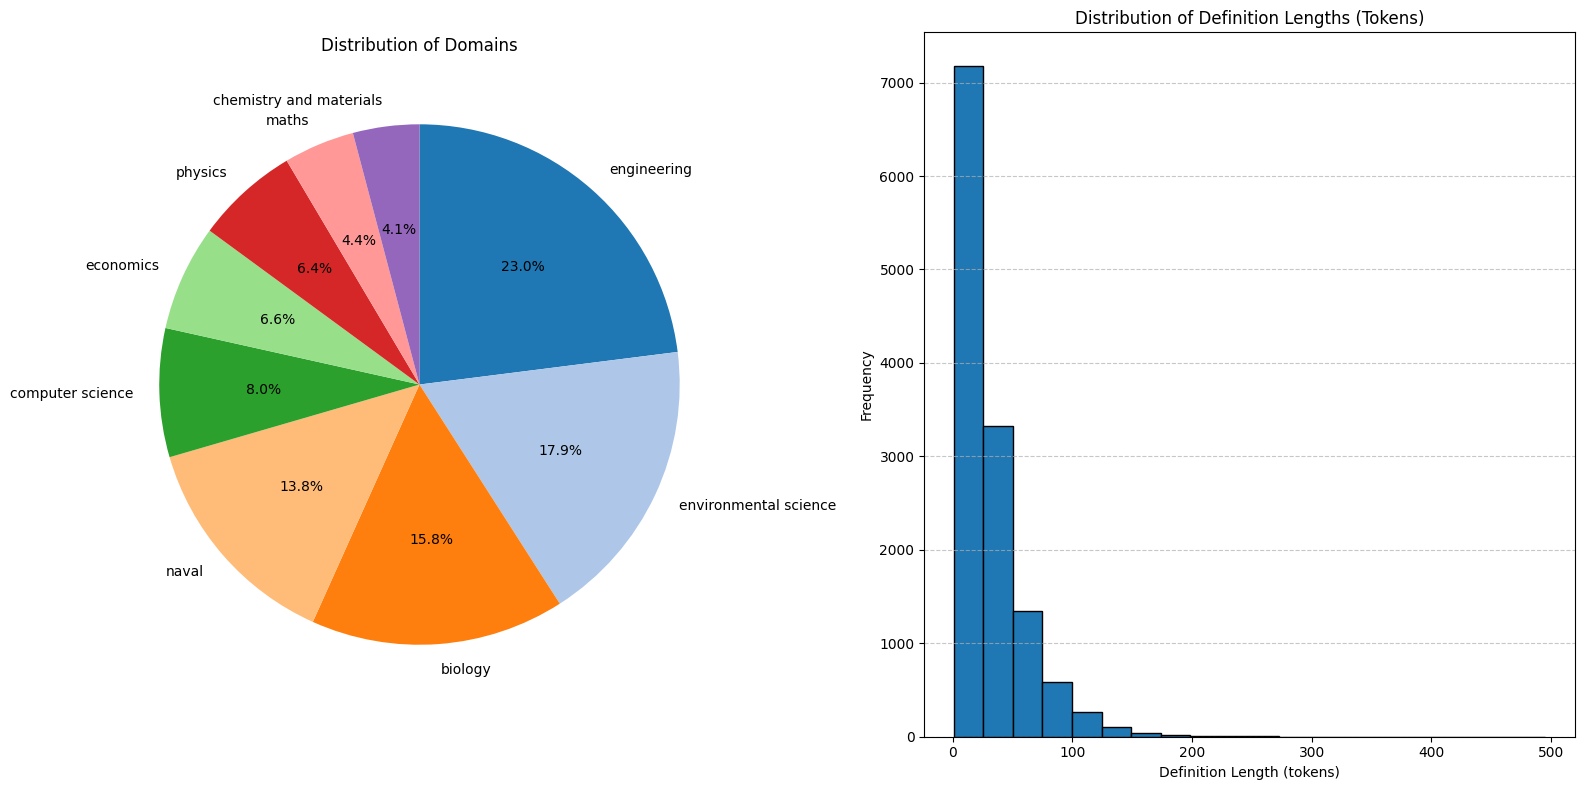

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file (update 'your_file.csv' to your file path)
file_path = 'SciWiGlossaries.csv'
data = pd.read_csv(file_path)


# Calculate the length of each definition
data['definition_length'] = data['answer'].apply(lambda x: len(x.split()))

def create_combined_visualizations(data):
    # Count terms per domain
    domain_counts = data['domain'].value_counts()

    # Sort the data by size in descending order
    domain_counts = domain_counts.sort_values(ascending=False)

    # Create a combined figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Pie chart
    axes[0].pie(
        domain_counts,
        labels=domain_counts.index,
        autopct='%1.1f%%',
        startangle=90,  # Start at 12 o'clock
        colors=plt.cm.tab20.colors,
        counterclock=False  # Make the slices go clockwise
    )
    axes[0].set_title("Distribution of Domains")

    # Histogram of definition lengths in tokens
    axes[1].hist(
        data['definition_length'],
        bins=20,
        edgecolor='black'
    )
    axes[1].set_title("Distribution of Definition Lengths (Tokens)")
    axes[1].set_xlabel("Definition Length (tokens)")
    axes[1].set_ylabel("Frequency")
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout and save the combined image
    plt.tight_layout()
    plt.savefig("combined_visualizations.png")
    plt.show()

create_combined_visualizations(data)

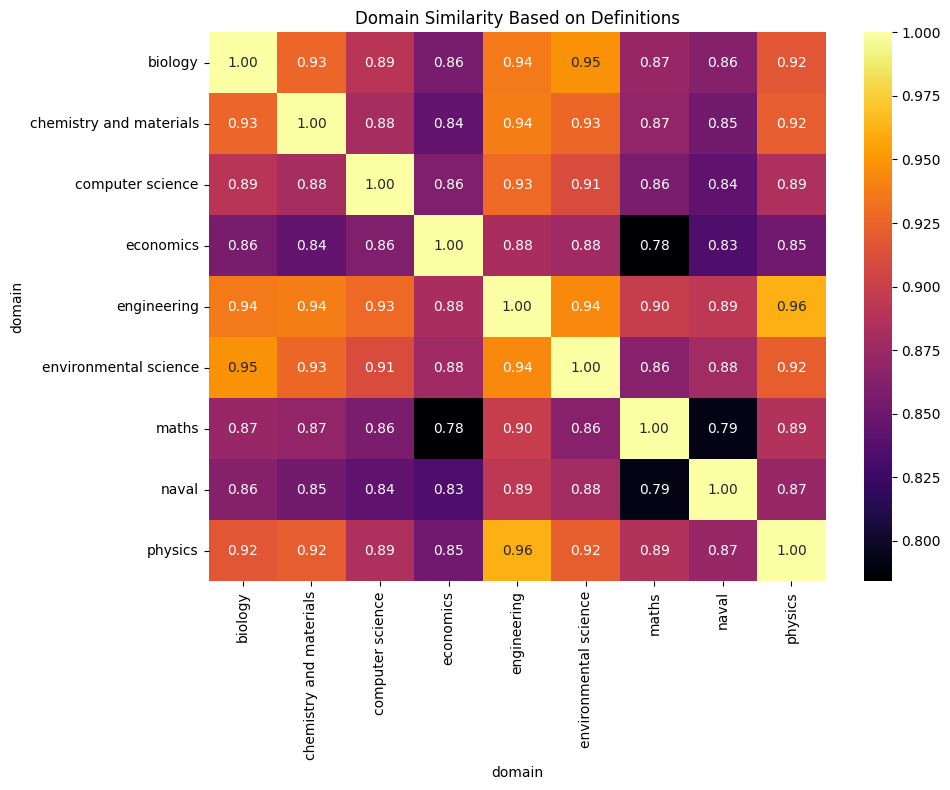

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Load the dataset
def main():
    # Load the CSV file (update 'your_file.csv' to your file path)
    file_path = 'SciWiGlossaries.csv'
    data = pd.read_csv(file_path)

    # Ensure required columns exist
    if not all(col in data.columns for col in ['answer', 'domain']):
        raise ValueError("The CSV file must contain 'definition' and 'domain' columns.")

    # Compute domain similarity
    compute_domain_similarity(data)

def compute_domain_similarity(data):
    # Combine all definitions per domain
    domain_definitions = data.groupby('domain')['answer'].apply(' '.join)

    # Vectorize the definitions using TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(domain_definitions)

    # Compute cosine similarity
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Convert to a DataFrame for visualization
    similarity_df = pd.DataFrame(
        similarity_matrix, 
        index=domain_definitions.index, 
        columns=domain_definitions.index
    )

    # Plot the similarity matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        similarity_df, 
        annot=True, 
        fmt=".2f", 
        cmap="inferno", 
        cbar=True,
        xticklabels=similarity_df.columns, 
        yticklabels=similarity_df.index
    )
    plt.title("Domain Similarity Based on Definitions")
    plt.tight_layout()
    plt.savefig("domain_similarity.png")
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd

data = pd.read_csv("SciWiGlossaries")

c:\Users\trewe\miniconda3\envs\bachelor_thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trewe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\trewe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\trewe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


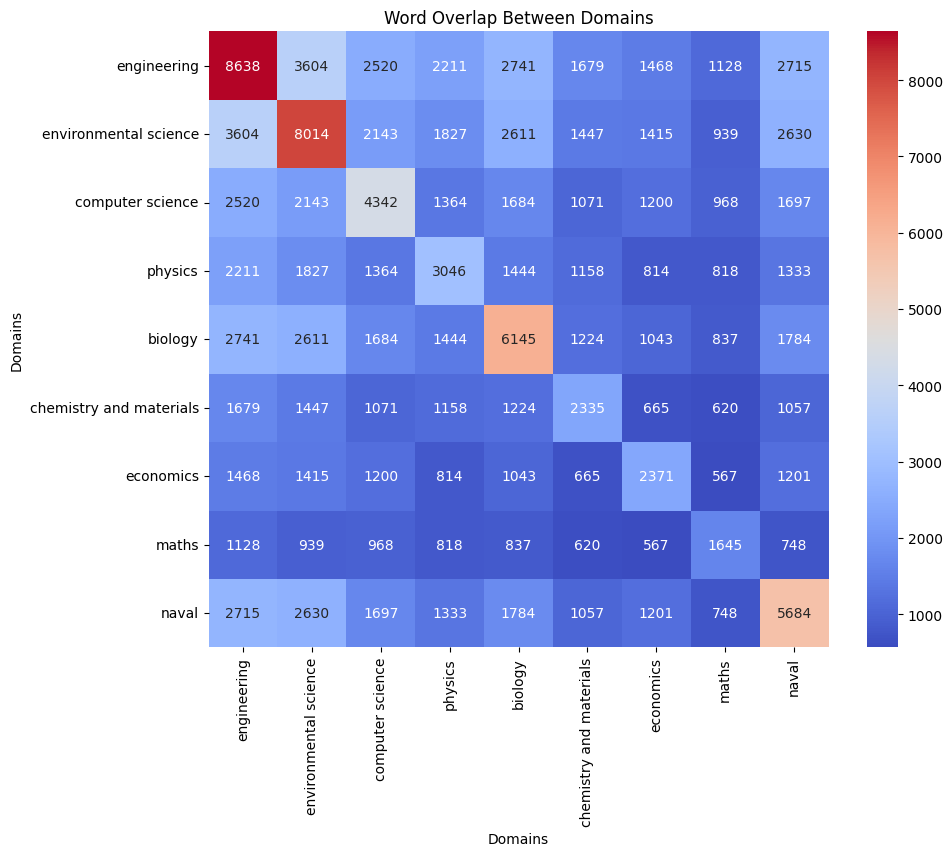

In [45]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Load data
data = pd.read_csv('SciWiGlossaries.csv')  # Replace with your CSV file path
data.columns = ["", 'question', 'answer', 'domain']

# Initialize NLP tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocess text
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic characters
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    return set(tokens)

# Create a dictionary to store word sets for each domain
domain_words = defaultdict(set)

# Process each row
for _, row in data.iterrows():
    domain = row['domain']
    text = row['question'] + " " + row['answer']
    processed_words = preprocess_text(text)
    domain_words[domain].update(processed_words)

# Calculate overlaps
domains = list(domain_words.keys())
overlap_matrix = pd.DataFrame(0, index=domains, columns=domains)

for i, domain1 in enumerate(domains):
    for j, domain2 in enumerate(domains):
        if i <= j:  # Avoid duplicate calculations
            overlap = len(domain_words[domain1].intersection(domain_words[domain2]))
            overlap_matrix.loc[domain1, domain2] = overlap
            overlap_matrix.loc[domain2, domain1] = overlap

# Visualize overlaps
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title('Word Overlap Between Domains')
plt.xlabel('Domains')
plt.ylabel('Domains')
plt.show()
